In [1]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, make_scorer
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import time

In [2]:
mnist = fetch_openml('mnist_784', as_frame = False)

In [3]:
X, y = mnist.data, mnist.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state = 42, stratify=y)

In [4]:
X_train, X_test, y_train, y_test = X_train[:10000], X_test[:2000], y_train[:10000], y_test[:2000]

In [5]:
y_train, y_test = y_train.astype('int64'), y_test.astype('int64')

In [6]:
param_grid = {'criterion':['entropy'], 'random_state':[42], 'max_features': [100, 150, 200], 'max_depth': [2, 4, 5]}
scorers = {'accuracy':make_scorer(accuracy_score), 'f1':make_scorer(f1_score, average="macro")}

tree = DecisionTreeClassifier()
tree_clf = GridSearchCV(tree, param_grid, cv=5, scoring=scorers, refit='accuracy')
tree_clf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['entropy'], 'max_depth': [2, 4, 5],
                         'max_features': [100, 150, 200],
                         'random_state': [42]},
             refit='accuracy',
             scoring={'accuracy': make_scorer(accuracy_score, response_method='predict'),
                      'f1': make_scorer(f1_score, response_method='predict', average=macro)})

In [7]:
print(f"The best hyperparameter values are: {tree_clf.best_params_}")

The best hyperparameter values are: {'criterion': 'entropy', 'max_depth': 5, 'max_features': 200, 'random_state': 42}


The best hyperparameter values are the biggest values that we give. This means that, these may not be the true best values and if we give even bigger values they could be even better.

In [8]:
param_combinations = tree_clf.cv_results_["params"]

test_results = []

for params in param_combinations:

    start = time.time()
    tree.fit(X_train, y_train)
    stop = time.time()
    training_time = stop-start
   
    y_test_pred = tree.predict(X_test)
    
    test_acc = accuracy_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred, average="macro")

    test_results.append({
        "parameters": params,
        "accuracy": test_acc,
        "f1_score": test_f1,
        "time": training_time
    })
    

test_results_df = pd.DataFrame(test_results)
print(round(test_results_df, 4))

                                          parameters  accuracy  f1_score  \
0  {'criterion': 'entropy', 'max_depth': 2, 'max_...    0.8005    0.7965   
1  {'criterion': 'entropy', 'max_depth': 2, 'max_...    0.8005    0.7961   
2  {'criterion': 'entropy', 'max_depth': 2, 'max_...    0.8075    0.8036   
3  {'criterion': 'entropy', 'max_depth': 4, 'max_...    0.8035    0.7996   
4  {'criterion': 'entropy', 'max_depth': 4, 'max_...    0.8060    0.8019   
5  {'criterion': 'entropy', 'max_depth': 4, 'max_...    0.8030    0.7988   
6  {'criterion': 'entropy', 'max_depth': 5, 'max_...    0.8030    0.7990   
7  {'criterion': 'entropy', 'max_depth': 5, 'max_...    0.8000    0.7967   
8  {'criterion': 'entropy', 'max_depth': 5, 'max_...    0.8060    0.8025   

     time  
0  3.2068  
1  3.1589  
2  3.2395  
3  3.2272  
4  3.2254  
5  3.2318  
6  3.2528  
7  3.3156  
8  3.1749  


In [9]:
pca_tree = make_pipeline(
    StandardScaler(), #The scaler is not needed for the Decicion Tree but for the PCA
    PCA(n_components=0.90, random_state=42),
    DecisionTreeClassifier(criterion='entropy', random_state=42, max_depth=5, max_features=200)
    )

In [10]:
start = time.time()
pca_tree.fit(X_train, y_train)
stop = time.time()
print(f"Training time: {stop-start}")

Training time: 4.811991453170776


In [11]:
print(f"The number of components selected by PCA are:{pca_tree.named_steps['pca'].n_components_}")

The number of components selected by PCA are:203


In [12]:
y_test_pred = pca_tree.predict(X_test)

test_acc = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred, average="macro")

print(f"accuracy after PCA: {round(test_acc, 4)}, f1_score after PCA: {round(test_f1, 4)}")

accuracy after PCA: 0.6545, f1_score after PCA: 0.6472


The accuracy and the F1-score of the decision tree is approximately 18% lower after the PCA transformation. The time needed to fit the pipeline (scaler, pca, tree) to the dataset is larger than that of fitting only the tree. So in this dataset, PCA doesn't reduce the dimensionality significantly and the training of the whole pipeline is slower. PCA doesn't have any important advantages on this scenario. In other problems, PCA could reduce fitting time or improve visualization.

In [13]:
gbc = GradientBoostingClassifier(max_depth=2, n_estimators=6, learning_rate=1.0, random_state=42)

In [14]:
pca = make_pipeline(
    StandardScaler(),
    PCA(n_components=203, random_state=42)
)

X_train_reduced = pca.fit_transform(X_train)
X_test_reduced = pca.transform(X_test)

In [15]:
start = time.time()
gbc.fit(X_train_reduced, y_train)
end = time.time()
time_elapsed = end - start

In [16]:
y_test_pred = gbc.predict(X_test_reduced)
test_acc = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred, average="macro")

print(f"accuracy: {test_acc:.4f}, f1_score: {test_f1:.4f}, train_time: {time_elapsed:.4f}")

accuracy: 0.7905, f1_score: 0.7875, train_time: 54.5775


Gradient Boosting is an ensemble method that uses sequential learning. Each new tree learns only the most important features and corrects the errors from the previous errors. On the other hand, a deeper Tree Classifier may lead to overfitting. That is why the gradient boostin classifier outperforms the tree classifier.

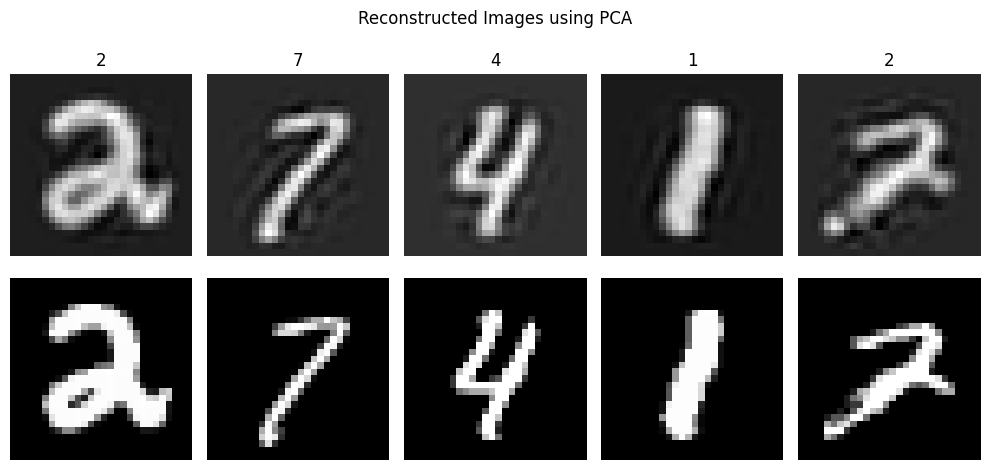

In [17]:
X_train_reconstructed = pca.inverse_transform(X_train_reduced)  
original_images = X_train.reshape(-1, 28, 28) 
reconstructed_images = X_train_reconstructed.reshape(-1, 28, 28)

fig, axes = plt.subplots(2, 5, figsize=(10, 5))

for i in range(5):

    axes[0, i].imshow(reconstructed_images[i], cmap='gray')
    axes[0, i].set_title(y_train[i])
    axes[0, i].axis("off")
    axes[1, i].imshow(original_images[i], cmap='gray')
    axes[1, i].axis("off")
    
plt.suptitle("Reconstructed Images using PCA")
plt.tight_layout()
plt.show()

The reconstructed images (first line) have lost some of the details and appear blurry but they still preserve the general shape of the digits. If we had choosen a higher number of principal components we would have a better quality.

In [18]:
km = KMeans(n_clusters=20, random_state=42)
start = time.time()
km.fit(X_train_reduced, y_train)
end = time.time()
time_elapsed = end - start

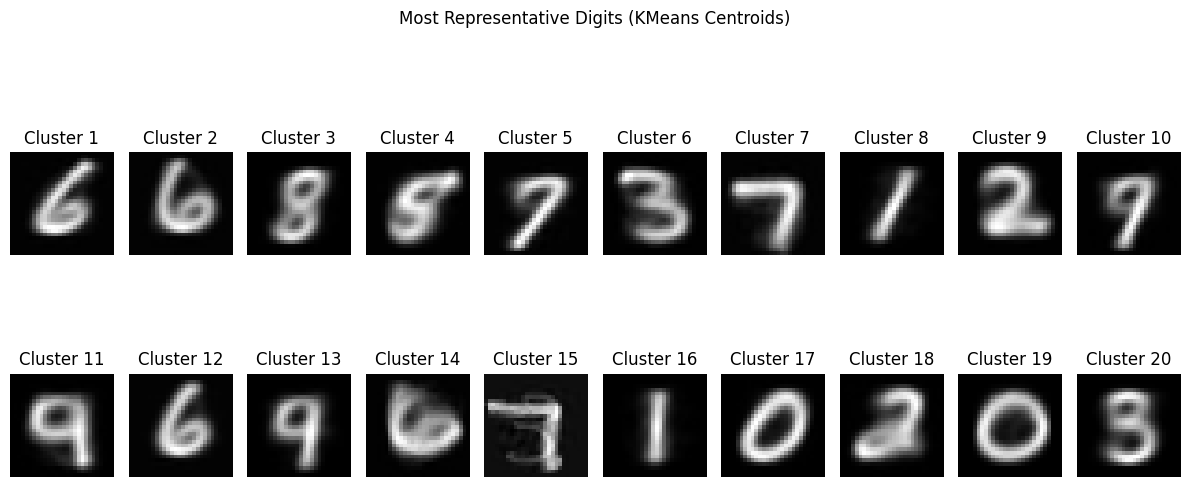

In [19]:
cluster_centroids = km.cluster_centers_
reconstructed_centroids = pca.inverse_transform(cluster_centroids)
centroid_images = reconstructed_centroids.reshape(-1, 28, 28)
fig, axes = plt.subplots(2, 10, figsize=(12,6))

for i, ax in enumerate(axes.flat):
    ax.imshow(centroid_images[i], cmap='gray')
    ax.set_title(f"Cluster {i+1}")
    ax.axis("off")

plt.suptitle("Most Representative Digits (KMeans Centroids)")
plt.tight_layout()
plt.show()

In [20]:
y_manually_labelled = np.array([6, 6, 8, 5, 7, 3, 7, 1, 2, 9, 9, 6, 9, 6, 7, 1, 0, 2, 0, 3])

In [21]:
distances = cdist(X_test_reduced, cluster_centroids) 

closest_clusters = np.argmin(distances, axis=1)  

y_pred = y_manually_labelled[closest_clusters]

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average="weighted")

print(f"Clustering-Based Label Propagation Accuracy: {accuracy:.4f}")
print(f"Clustering-Based Label Propagation F1-score: {f1:.4f}")
print(f"Training Time: {time_elapsed:.4f}")

Clustering-Based Label Propagation Accuracy: 0.5595
Clustering-Based Label Propagation F1-score: 0.5256
Training Time: 0.7451


We can see that k-means is much faster than the previous algorithms but has an important loss in accuracy and F1-score. We may choose k-means only if the training dataset is very big and fitting time is an important parameter.